# Face Generation

Student: Angel Martinez-Tenor <br/>
Deep Learning Nanodegree Foundation - Udacity <br/>
May 13, 2017 <br/>

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

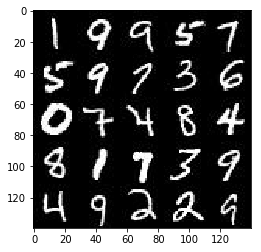

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

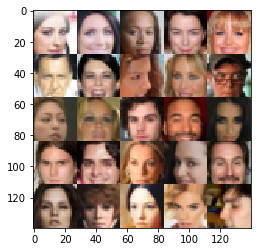

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # EXERCISE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learing_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Discriminator. Number of Convolutional layers tested: 2-3
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 (MNIST) or 28x28x3 (ceb faces)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128  
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
#       # 4x4x256   

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Generator. Number of Convolutional layers tested: 2-3
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x1 (MNIST) or 28x28x3 (ceb faces)  now
        
        out = tf.tanh(logits)
        
        return out    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Model Loss
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    soft = 0.9 # one-sided label smoothing (feedback from reviewer)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*soft))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)*soft))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # EXERCISE: Implement Function
    
    # From DCGAN.ipynb Optimizers
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  # from project-5 slack channel
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return d_train_opt, g_train_opt  
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    #example_z = np.random.normal(1, 1, size=[n_images, z_dim])


    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # EXERCISE: Build Model
    
    # Adapted from DCGAN.ipynb Building the model, GAN class

    # tf.reset_default_graph() cannot be used here as train is called within tf.Graph().as_default()
    
    #print(data_shape)
    assert ((data_image_mode == "L" and data_shape[3] == 1) or 
            (data_image_mode == "RGB" and data_shape[3] == 3)), \
            ("Image mode Inconsistency: ", data_image_mode, " mode, ", data_shape[2], " channels")
    out_channel_dim = data_shape[3]    
        
    input_real, input_z, lr_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        samples, losses = [], []
        steps = 0
        show_every = 100
        print_every = 30
        sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
        # sample_z = np.random.normal(0, 1, size=(50, z_dim))
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # EXERCISE: Train Model
                
                # Adapted from DCGAN.ipynb Building the model, train function
                
                steps += 1

                batch_images *= 2  # Normalizing from [-0.5,0.5 to -1,1]  (feedback from reviewer)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate, input_real: batch_images})
                    # 2x generator optimizer as suggested in the forum
                # _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate}) 

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr_placeholder: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr_placeholder: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                          
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.6135... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 2.2508... Generator Loss: 4.4415
Epoch 1/2... Discriminator Loss: 2.7489... Generator Loss: 0.3344


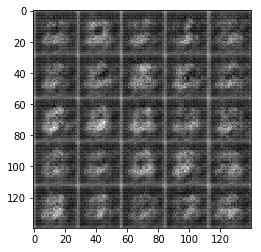

Epoch 1/2... Discriminator Loss: 2.2611... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.0878
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 1.2148


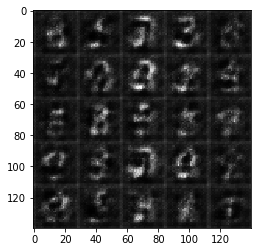

Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.4685


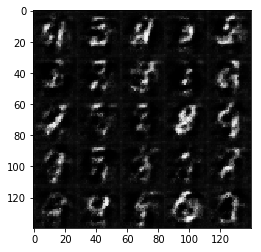

Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 0.3952
Epoch 1/2... Discriminator Loss: 1.8748... Generator Loss: 0.3825


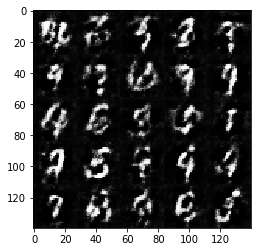

Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.5361


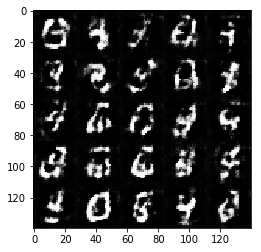

Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 2.0922
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5469


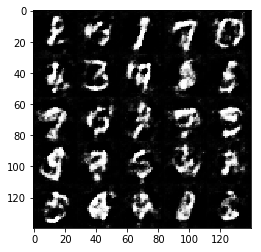

Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 1.7462... Generator Loss: 0.4197


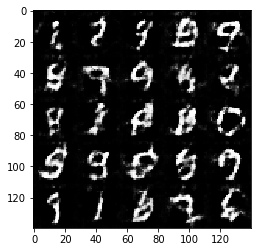

Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.5245


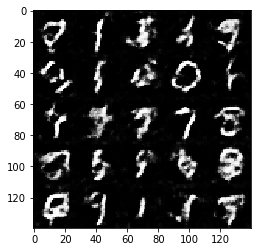

Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.0273
Epoch 1/2... Discriminator Loss: 2.0762... Generator Loss: 0.3668
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.1920


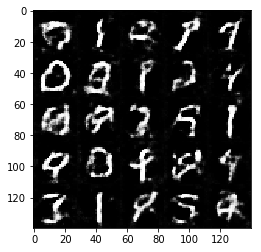

Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.1855
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 1.4220


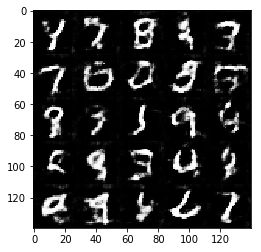

Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.6051


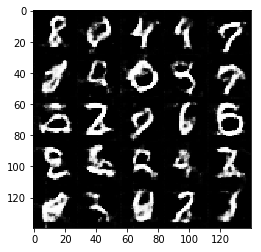

Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.5351... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 1.7667... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 0.9122


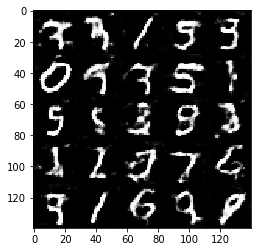

Epoch 1/2... Discriminator Loss: 1.8421... Generator Loss: 0.3834
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.5078


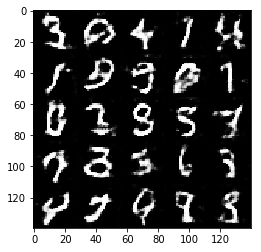

Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.5390


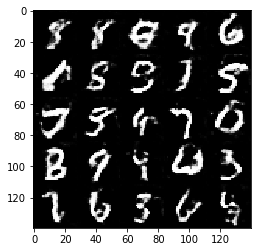

Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.0983


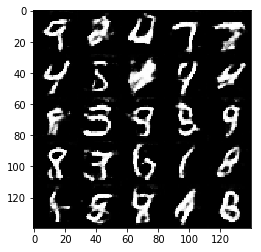

Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.0266
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.4530


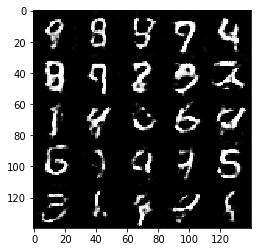

Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 2.3471
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 2.5416


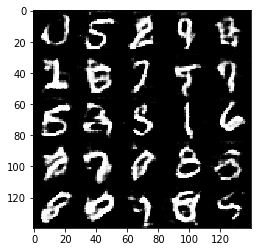

Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.7288


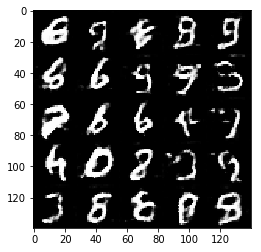

Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.5402... Generator Loss: 0.5649


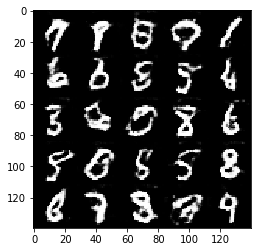

Epoch 2/2... Discriminator Loss: 1.4911... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.0920


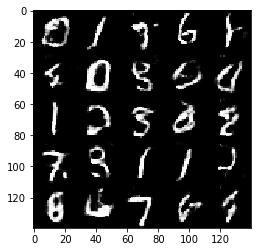

Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.6813... Generator Loss: 2.9136
Epoch 2/2... Discriminator Loss: 1.7628... Generator Loss: 0.4664
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 0.9103


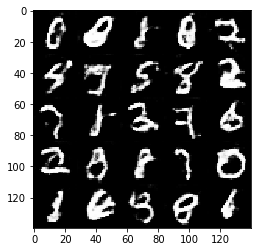

Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.7997
Epoch 2/2... Discriminator Loss: 0.7697... Generator Loss: 1.0893
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.1490


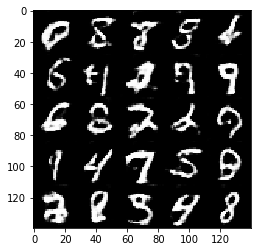

Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 2.6442
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.4845


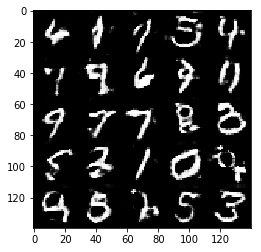

Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.7400


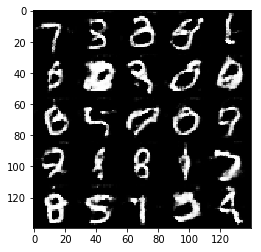

Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.5624


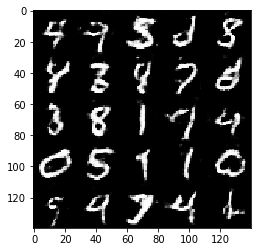

Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.5341


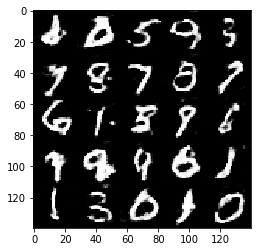

Epoch 2/2... Discriminator Loss: 2.4532... Generator Loss: 3.7042
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.5461


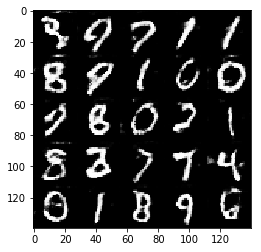

Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.4306
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 0.7075... Generator Loss: 1.3444


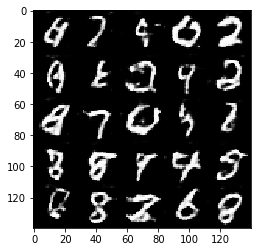

Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.5184
Epoch 2/2... Discriminator Loss: 0.8921... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 0.7890


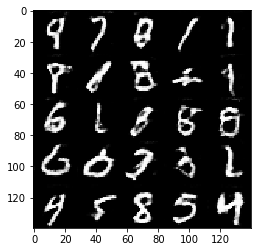

Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.6930
Epoch 2/2... Discriminator Loss: 2.8602... Generator Loss: 0.3500


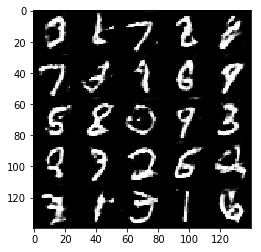

Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 1.8716


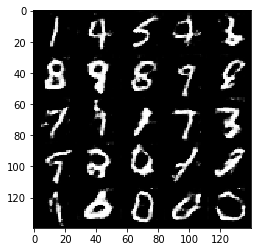

Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 2.4757... Generator Loss: 0.3674


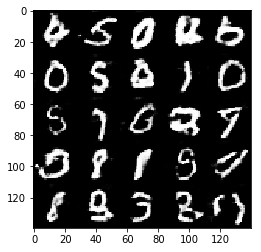

Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 1.5932
Epoch 2/2... Discriminator Loss: 1.9569... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 2.2643... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 0.8943


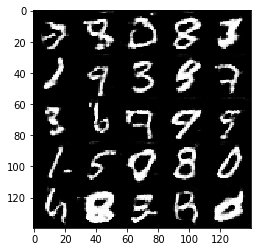

Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.9767
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 2.4662


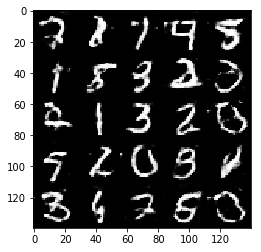

Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.6094
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 1.7941
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 3.9573


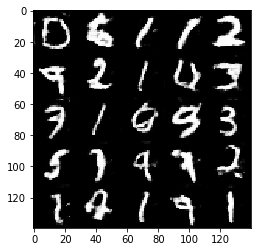

Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 1.3847
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 2.6074
Epoch 2/2... Discriminator Loss: 1.7296... Generator Loss: 0.5960


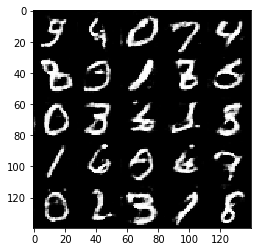

Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 2.2020... Generator Loss: 0.4245
Epoch 2/2... Discriminator Loss: 0.5441... Generator Loss: 1.8322


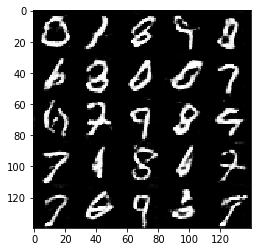

Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 1.6670
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 1.7523


In [12]:
batch_size = 32        # tested from 32 to 256
z_dim = 100            # tested from 50 to 200
learning_rate = 0.0002 # tested from 0.00001 to 0.02  
beta1 = 0.1            # tested from 0.01 to 0.7
# some values were suggested by reviewer

# Note: The parameters have been tuned to generate accurate handwritten digits. 
#  Lower generator losses can be achieved with worse images.   

tf.reset_default_graph()  # added

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.1624... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 4.5532
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.2448


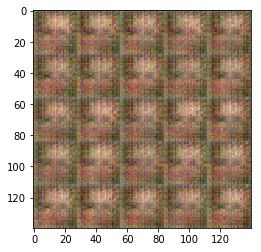

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.2141


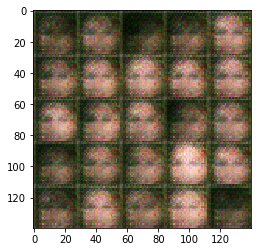

Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 2.0017... Generator Loss: 4.0342
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 2.3966... Generator Loss: 0.3349


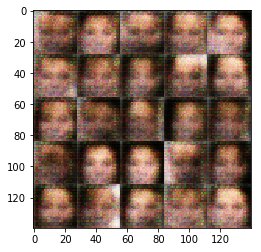

Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 0.8195


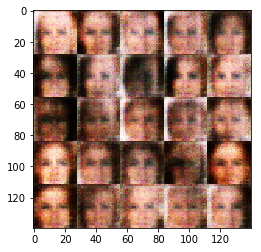

Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.7817


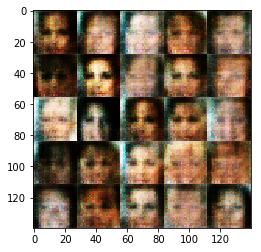

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5918


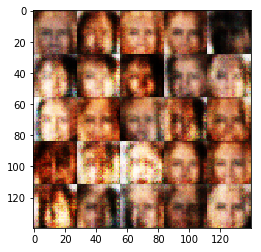

Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6434


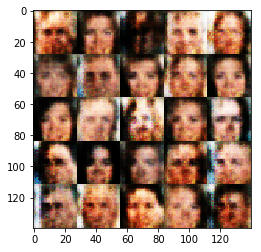

Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5476


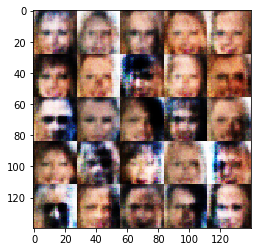

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6990


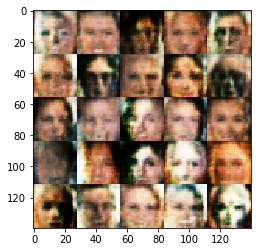

Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2783


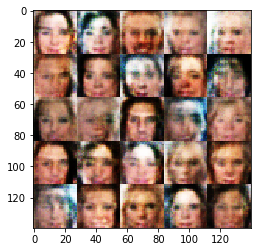

Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.5304


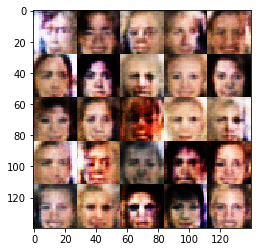

Epoch 1/1... Discriminator Loss: 1.9054... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 1.8001
Epoch 1/1... Discriminator Loss: 1.9121... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.7658


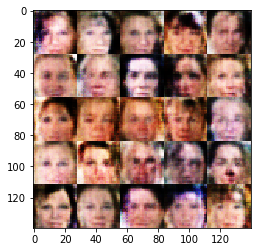

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.6940


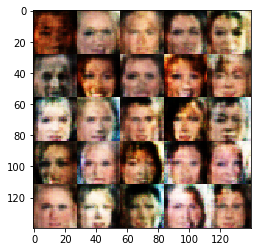

Epoch 1/1... Discriminator Loss: 2.0366... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.4345


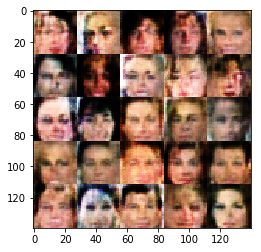

Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.9345


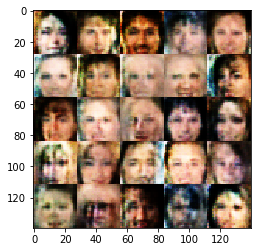

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 2.1024... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 2.3340... Generator Loss: 0.3405


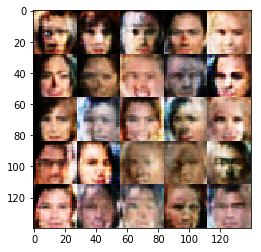

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.9108


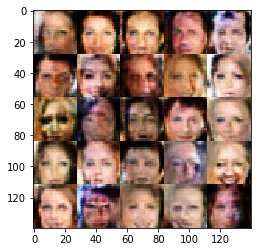

Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.7693
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.3161


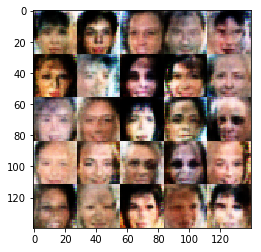

Epoch 1/1... Discriminator Loss: 2.0135... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.8359... Generator Loss: 0.4034


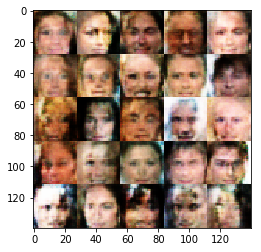

Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 1.7968... Generator Loss: 0.4011


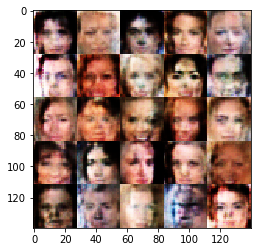

Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.4474


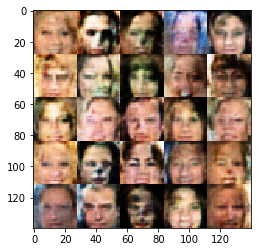

Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.7919... Generator Loss: 1.3547


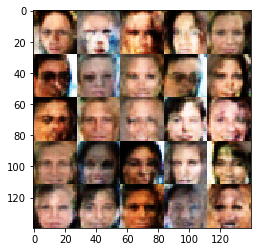

Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.8561... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.7375


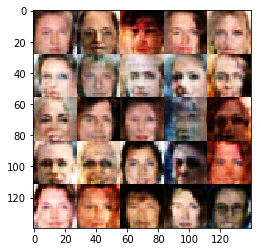

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.6066
Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.9281


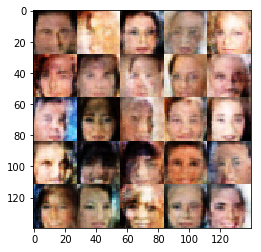

Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 2.0279


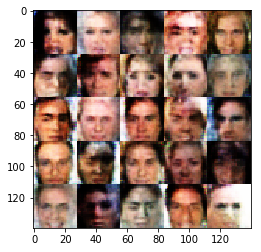

Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 2.0824... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.9650... Generator Loss: 0.3795


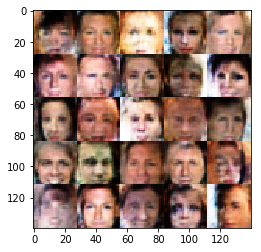

Epoch 1/1... Discriminator Loss: 2.0687... Generator Loss: 3.3244
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 1.6161


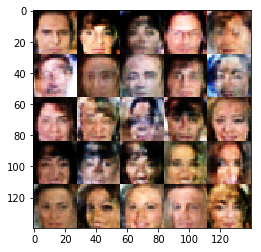

Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 2.1051
Epoch 1/1... Discriminator Loss: 2.2201... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.1708


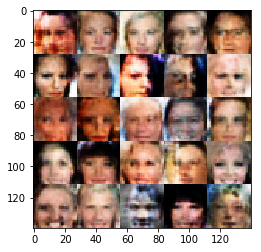

Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.3989


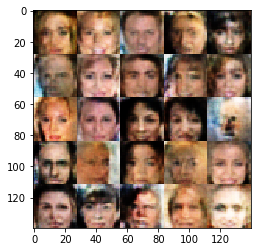

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6028


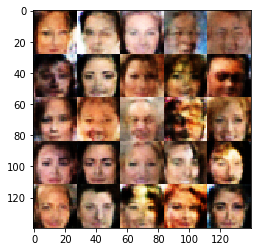

Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 2.7991
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.2893


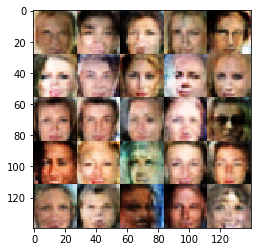

Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.8922


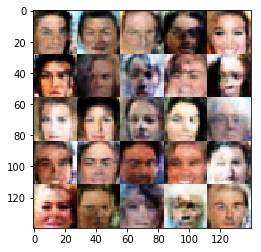

Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 2.1315
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 2.2289
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 1.8929


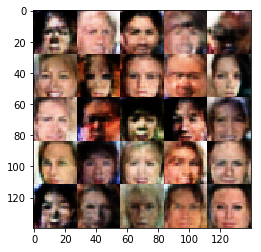

Epoch 1/1... Discriminator Loss: 2.1665... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 3.1380
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.8012


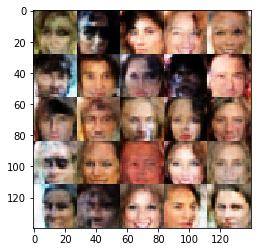

Epoch 1/1... Discriminator Loss: 2.0171... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 2.1995


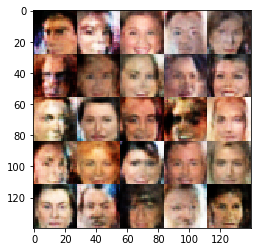

Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.1030


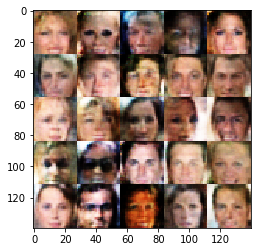

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.9522
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 2.2953... Generator Loss: 0.3424


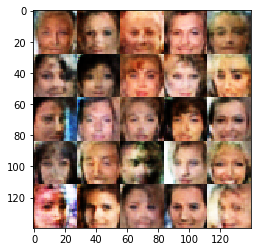

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.5607


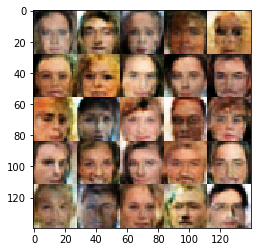

Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 2.0839
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 2.9514
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.8635


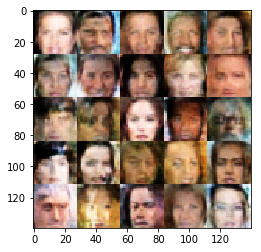

Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.5361


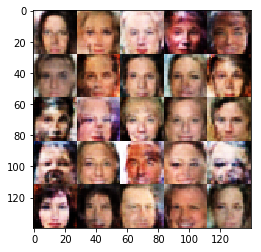

Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.8706


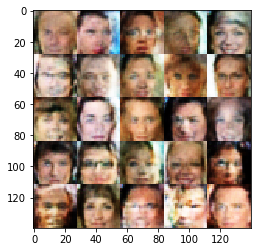

Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 2.1068... Generator Loss: 0.3491
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 2.0134
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.3466


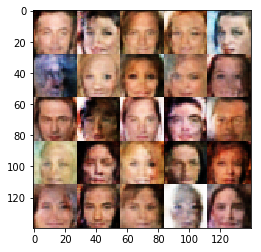

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 2.0161
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.6701


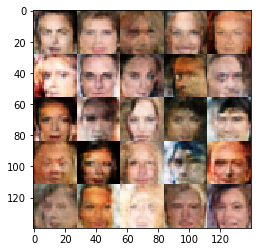

Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.8319... Generator Loss: 2.5492
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 2.1593


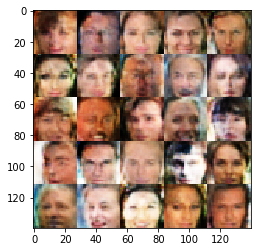

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.9122... Generator Loss: 0.3817


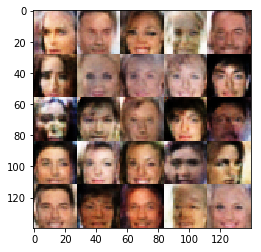

Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 2.9929
Epoch 1/1... Discriminator Loss: 2.1413... Generator Loss: 0.3489


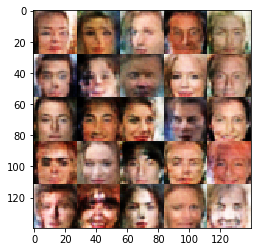

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.5414


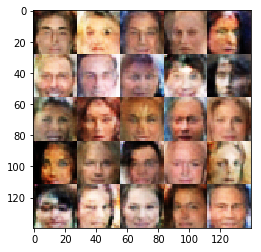

Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.6115


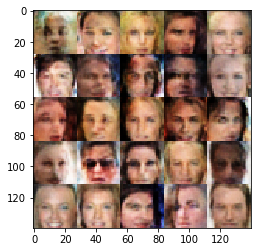

Epoch 1/1... Discriminator Loss: 2.1198... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.3028


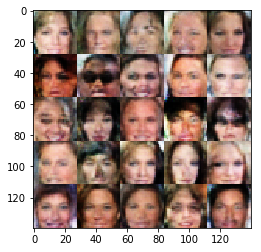

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.5448


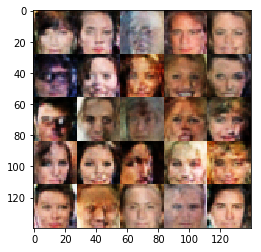

Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 1.9693... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.0491


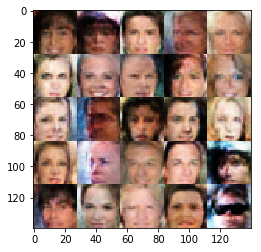

Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.1616


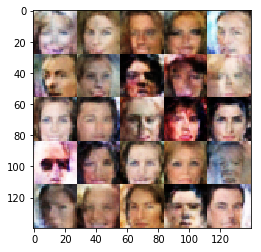

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.4771


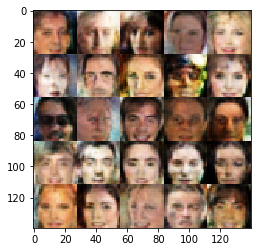

Epoch 1/1... Discriminator Loss: 1.8336... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.4495


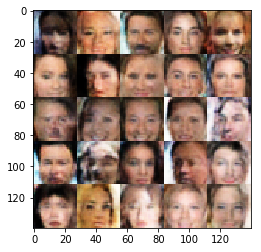

Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7300


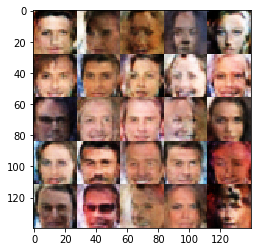

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5251


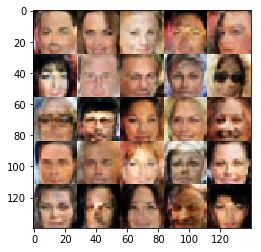

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.4088


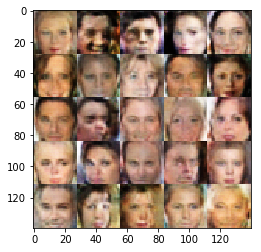

Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 2.0030
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.9980


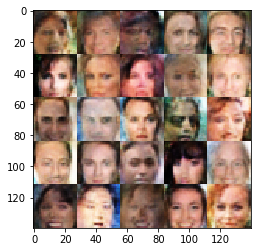

Epoch 1/1... Discriminator Loss: 1.6814... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.2969


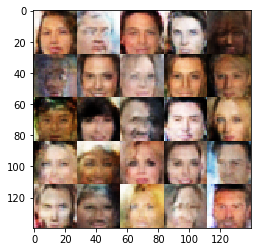

Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 2.0015... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.9931... Generator Loss: 2.6249


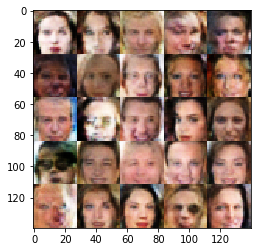

Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.8369
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8596


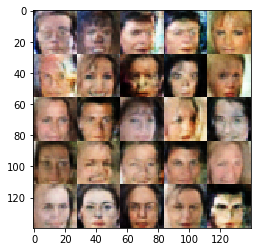

Epoch 1/1... Discriminator Loss: 1.8827... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.4901


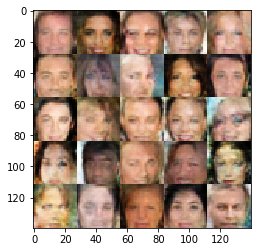

Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 1.8193... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.3837


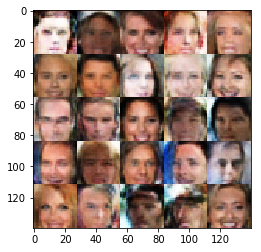

Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.6287


In [13]:
batch_size = 32        # tested from 32 to 256         
z_dim = 100            # tested from 50 to 200
learning_rate = 0.0002 #tested from 0.00001 to 0.02
beta1 = 0.1            # tested from 0.01 to 0.7
# some values were suggested by reviewer

tf.reset_default_graph() # added

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.